In [140]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [141]:
!pip install -Uq fastai

In [142]:
from pathlib import Path

data_root=Path('/data/wood-species/hand-cleaned')
data_dirs = [x for x in data_root.iterdir() if x.is_dir()]


In [143]:
from fastai.vision.all import *

class WoodPicture:
    def __init__(self, name, path, dataset):
        self.name = name
        self.path = path
        self.dataset = dataset

    def image(self):
        return Image.open(self.path)

class WoodPictures:
    def __init__(self, path):
        self.path = path
        self.name = path.name
        self.image_files = [x for x in path.iterdir() if self.use_file(x)]
                                                                                                                  
    def use_file(self, f):
        if not f.is_file(): return False 
        if not f.match('*.jpg'): return False
        if f.match('*web.*') or f.match('*end grain*'): return False
        return True

    def images(self):
        images = []
        for x in self.image_files:
            dataset = 'valid' if random.random() < 0.2 else 'train'
            images.append(WoodPicture(self.name, x, dataset))
        return images

In [144]:
# Load all images
woods = [WoodPictures(x) for x in data_dirs]
len(woods)

423

In [145]:
#from tqdm.notebook import tqdm

#for wood in tqdm(woods, desc="Checking woods for broken images"):
#    for image in wood.images():
#        if not verify_image(image.path):
#            print("- Broken image:", image.path)

In [146]:
# wood = woods[10]
# print(f"Name: {wood.name}")
# images = wood.images()
# images[1].image().to_thumb(512,512)

In [159]:
training_woods = woods
images = [x for wood in training_woods for x in wood.images()]
len(images)

14443

In [160]:
# Check train/validation dataset split
from collections import Counter
Counter([i.dataset for i in images])

Counter({'train': 11591, 'valid': 2852})

In [161]:
def get_images(x):
    return x

def get_path(x):
    return x.path
    
def get_name(x):
    return x.name

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_images,
    get_x=get_path,
    get_y=get_name,
    splitter=FuncSplitter(lambda o: o.dataset == 'valid'),
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms() + [RandomErasing(p=1., max_count=10, sh=0.1)],
).dataloaders(images, bs=32)

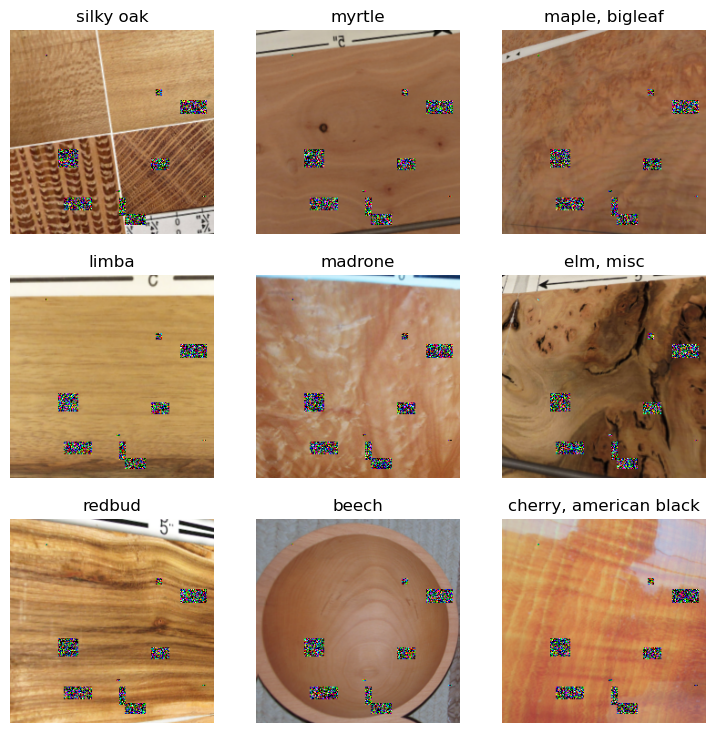

In [162]:
dls.train.show_batch()

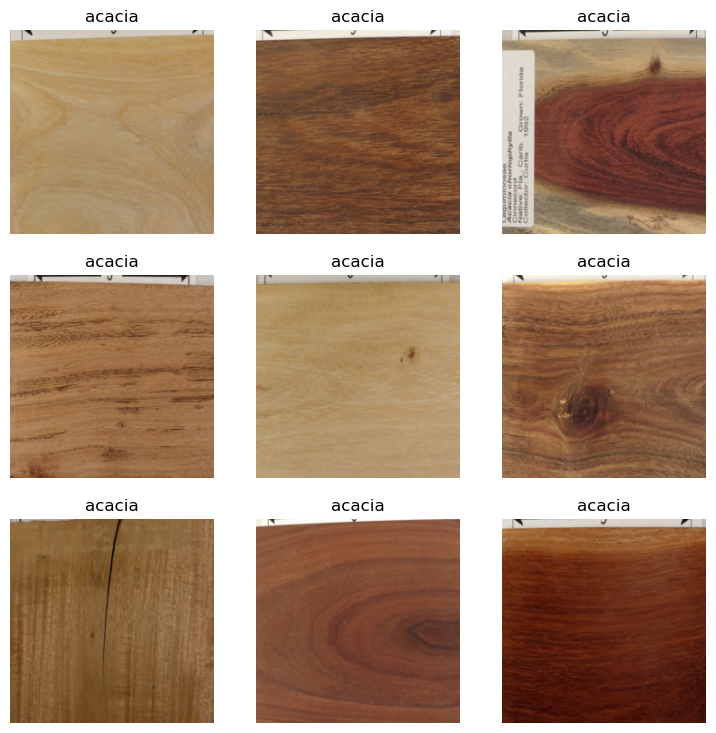

In [163]:
dls.valid.show_batch()

In [164]:
autoload_data = Path("/data/auto-save/models")
best_model = str(sorted(autoload_data.glob("model_0.*.pth"))[0]).replace('.pth', '')

In [166]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.load(best_model)

RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 1.8.weight: copying a param with shape torch.Size([359, 512]) from checkpoint, the shape in current model is torch.Size([405, 512]).

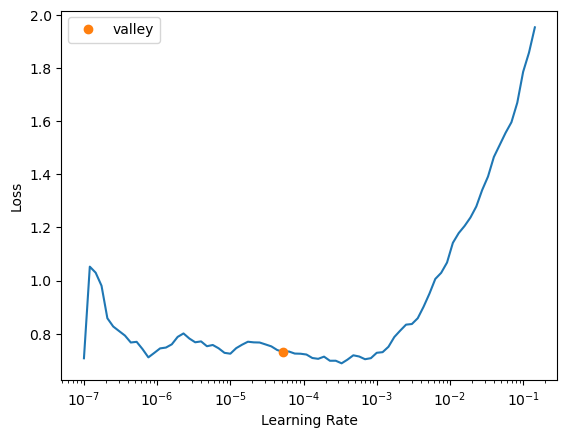

In [139]:
lr = learn.lr_find()

In [124]:
lr.valley

0.00015848931798245758

In [121]:
!mkdir -p /data/wood-classifier-dev

learn.path=Path("/data/wood-classifier-dev")
learn.fit_one_cycle(
    10, 
    lr_max = 1e-06,
    cbs=[
#        EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=3),
        SaveModelCallback(),
        ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=2),
    ]
)


epoch,train_loss,valid_loss,error_rate,time
0,1.840379,1.971080,0.467213,00:41
1,1.854345,1.566442,0.434426,00:42
2,1.888278,1.385838,0.418033,00:42
3,1.871290,1.330922,0.442623,00:42
4,1.845452,1.380618,0.426230,00:41
5,1.812217,1.339790,0.434426,00:41
6,1.794859,1.399076,0.409836,00:42
7,1.802317,1.358294,0.393443,00:41
8,1.794797,1.439092,0.385246,00:42
9,1.804792,1.419604,0.401639,00:41


Better model found at epoch 0 with valid_loss value: 1.9710798263549805.
Better model found at epoch 1 with valid_loss value: 1.5664420127868652.
Better model found at epoch 2 with valid_loss value: 1.3858380317687988.
Better model found at epoch 3 with valid_loss value: 1.3309217691421509.
Epoch 4: reducing lr to 7.612516459164099e-08
Epoch 6: reducing lr to 3.579986998472778e-08
Epoch 8: reducing lr to 4.871686000297067e-09


In [96]:
learn.fit_one_cycle(5, lr_max = 1e-06)

epoch,train_loss,valid_loss,error_rate,time
0,0.073631,0.669767,0.147541,00:41
1,0.065162,0.668331,0.131148,00:41
2,0.100432,0.672409,0.131148,00:40
3,0.096046,0.673834,0.147541,00:40
4,0.083986,0.674053,0.131148,00:41


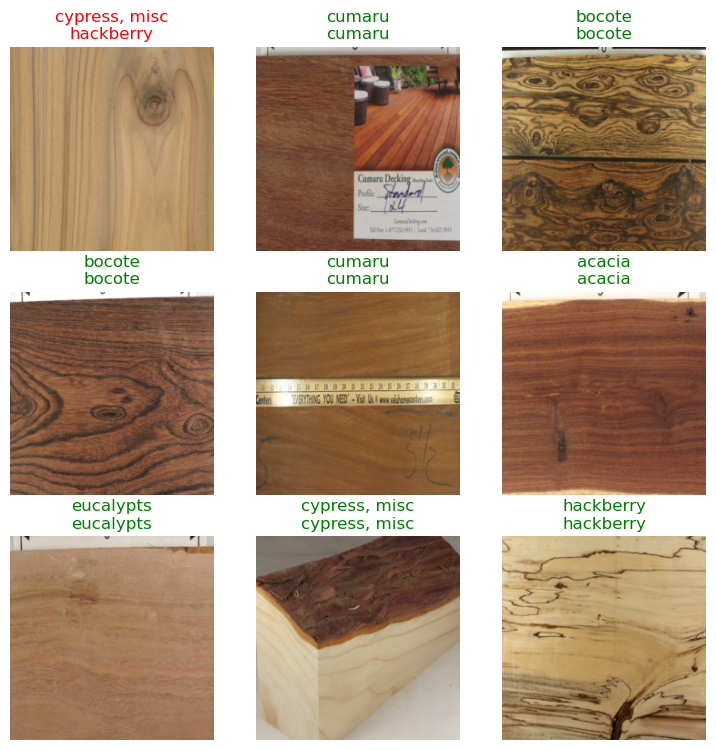

In [97]:
learn.show_results()

In [98]:
test_woods = ["bocote","chestnut"]
for test_wood in test_woods:
    test_dir = Path("../../test-images") / test_wood
    for x in test_dir.iterdir():
        if x.is_file():
            image = PILImage.create(x)
            name, _, _ = learn.predict(image)
            print(f"{x}: expected '{test_wood}', got '{name}'")

../../test-images/bocote/bocCloseup-small.jpg: expected 'bocote', got 'bocote'


../../test-images/bocote/bocote-v2.jpg: expected 'bocote', got 'bocote'


../../test-images/bocote/bocBF-small.jpg: expected 'bocote', got 'bocote'


../../test-images/bocote/bocote-1000x500-2.jpg: expected 'bocote', got 'bocote'


../../test-images/chestnut/wormy-chestnut@2x.webp: expected 'chestnut', got 'chestnut'


../../test-images/chestnut/istockphoto-182856415-1024x1024.jpg: expected 'chestnut', got 'chestnut'


../../test-images/chestnut/reclaimed-barnwood-farm-table_04.jpg: expected 'chestnut', got 'eucalypts'
